In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta
import matplotlib.dates as mdates

In [2]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [3]:
lumi_directory = data_directory = "./lumi"

In [4]:
int_lumi = pd.read_csv(("%s/int_lumi.csv" % lumi_directory),
           names=["run:fill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source"])

int_lumi2 = pd.read_csv(("%s/lumi_per_ls.csv" % lumi_directory),
           names=["run:fill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source"])

In [5]:
int_lumi['run'], int_lumi['fill'] = int_lumi['run:fill'].str.split(':', 1).str
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['run:fill'].str.split(':', 1).str
int_lumi['ls_start'], int_lumi['ls_end'] = int_lumi['ls'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str

In [6]:
int_lumi.drop(int_lumi.index[[0,1,2034,2035,2036]], inplace=True)
int_lumi2.drop(int_lumi2.index[[0,1,2034,2035,2036]], inplace=True)
#print int_lumi

In [7]:
int_lumi["run"] = int_lumi["run"].astype('int')
int_lumi2["run"] = int_lumi2["run"].astype('int')

#int_lumi["delivered"].dtype
#int_lumi2["run"].dtype

In [8]:
#print int_lumi2

In [9]:
int_lumi["delivered"] = int_lumi["delivered"].astype('float64')
int_lumi["recorded"] = int_lumi["recorded"].astype('float64')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 

In [10]:
int_lumi["delivered"].dtype
int_lumi["inst_lumi_del"] = int_lumi["delivered"]/23;
int_lumi["inst_lumi_rec"] = int_lumi["recorded"]/23;

In [11]:
pd.to_datetime(int_lumi["time"])
pd.to_datetime(int_lumi2["time"])
#print int_lumi2['time']

2      2017-11-17 21:48:20
3      2017-11-17 21:48:43
4      2017-11-17 21:49:06
5      2017-11-17 21:49:30
6      2017-11-17 21:49:53
7      2017-11-17 21:50:16
8      2017-11-17 21:50:40
9      2017-11-17 21:51:03
10     2017-11-17 21:51:26
11     2017-11-17 21:51:49
12     2017-11-17 21:52:13
13     2017-11-17 21:52:36
14     2017-11-17 21:52:59
15     2017-11-17 21:53:23
16     2017-11-17 21:53:46
17     2017-11-17 21:54:09
18     2017-11-17 21:54:33
19     2017-11-17 21:54:56
20     2017-11-17 21:55:19
21     2017-11-17 21:55:43
22     2017-11-17 21:56:06
23     2017-11-17 21:56:29
24     2017-11-17 21:56:53
25     2017-11-17 21:57:16
26     2017-11-17 21:57:39
27     2017-11-17 21:58:02
28     2017-11-17 21:58:26
29     2017-11-17 21:58:49
30     2017-11-17 21:59:12
31     2017-11-17 21:59:36
               ...        
2004   2017-11-18 10:46:08
2005   2017-11-18 10:46:31
2006   2017-11-18 10:46:55
2007   2017-11-18 10:47:18
2008   2017-11-18 10:47:41
2009   2017-11-18 10:48:05
2

In [12]:
def addTimeOffSet(data):
    startdate = data.time
    enddate = pd.to_datetime(startdate) + pd.DateOffset(seconds=23)
    return enddate

In [13]:
int_lumi["time_end"] = int_lumi["time"]
int_lumi2["time_end"] = int_lumi2["time"]

int_lumi["time_end"] = int_lumi.apply(addTimeOffSet, axis=1);
int_lumi2["time_end"] = int_lumi2.apply(addTimeOffSet, axis=1);

In [14]:
#print int_lumi["time"], int_lumi["time_end"]

In [15]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object
int_lumi["time"] = int_lumi.apply(transform_time, axis=1);
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

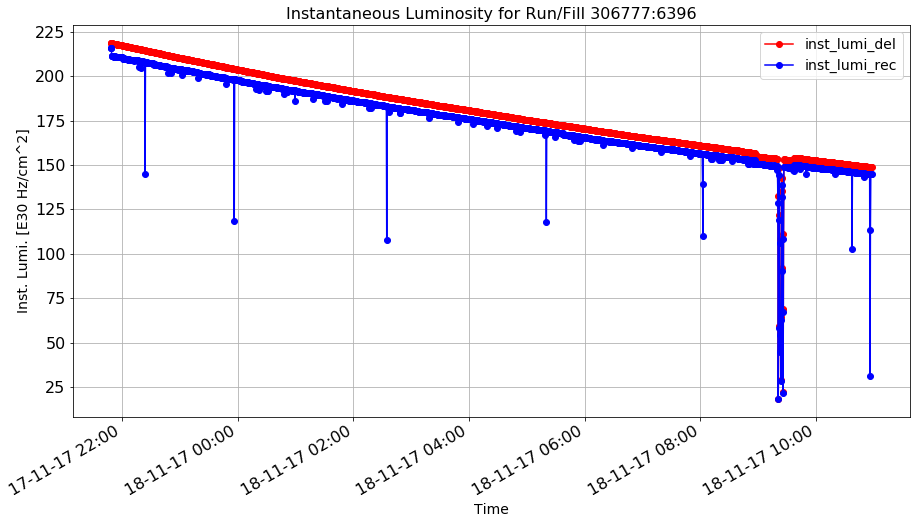

In [16]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    import datetime
    import matplotlib.dates as mdates
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Inst. Lumi. [E30 Hz/cm^2]")
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();
    
plot_inst_lumi(int_lumi["time"], int_lumi["inst_lumi_del"], int_lumi["inst_lumi_rec"], "Instantaneous Luminosity for Run/Fill "+int_lumi["run:fill"][2])

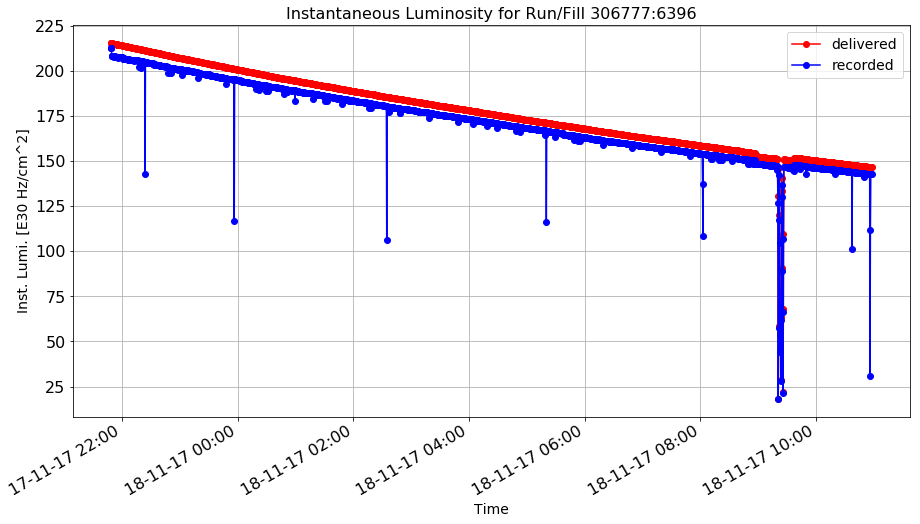

In [17]:
plot_inst_lumi(int_lumi2["time"], int_lumi2["delivered"], int_lumi2["recorded"], "Instantaneous Luminosity for Run/Fill "+int_lumi["run:fill"][2])

In [18]:
#int_lumi3 = pd.read_csv(("%s/lumi_per_bx.csv" % lumi_directory),
#           names=["run:fill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source", "bx"])

In [19]:
#int_lumi3.drop(int_lumi3.index[[0,1,2034,2035,2036]], inplace=True)
#int_lumi3['run'], int_lumi2['fill'] = int_lumi3['run:fill'].str.split(':', 1).str
#int_lumi3['ls_start'], int_lumi2['ls_end'] = int_lumi3['ls'].str.split(':', 1).str

In [20]:
#print int_lumi3["bx"]

In [21]:
def convertToArray(data):
    temp = data.split()
    temp2 = map(lambda each:each.strip("["),temp)
    temp3 = map(lambda each:each.strip("]"),temp2)
    return temp3
#int_lumi3["bx"] = int_lumi3["bx"].apply(convertToArray)

In [22]:
#print int_lumi3["bx"].iloc[0]
#print len(int_lumi3["bx"].iloc[0])

In [23]:
def slice_it(data, size):
    temp = zip(*[iter(data)]*size)
    return temp

def splitArray(data):
    temp = map(float, data)
    temp2 = slice_it(temp, 3)
    return temp2

In [24]:
#int_lumi3["bx"] = int_lumi3["bx"].apply(splitArray)

In [25]:
#print int_lumi3["bx"].iloc[0]

In [26]:
#newdf = pd.DataFrame()
def transform(olddf):
    list = olddf.iloc[0]
    tempDF = pd.DataFrame(list, columns = ['BX', 'lumiDel', 'lumiRec'])
    for i in range(1, len(olddf)):
        list = olddf.iloc[i]
        tempDF = tempDF.append(pd.DataFrame(list, columns = ['BX', 'lumiDel', 'lumiRec']))
    return tempDF

In [27]:
#newdf = transform(int_lumi3["bx"])

In [28]:
#print newdf

In [29]:
rates_directory = "./rates"
df_rates = pd.read_csv(("%s/dt_rates.csv" % rates_directory),
           names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"])
pd.to_datetime(df_rates["time"])
df_rates["run"] = df_rates["run"].astype('int')
df_rates["run"].dtype

dtype('int64')

In [30]:
#print df_rates

In [31]:
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str
df_rates["wheel"] = df_rates["wheel"].astype(str)
df_rates["sector"] = df_rates["sector"].astype(str)

In [32]:
#print df_rates

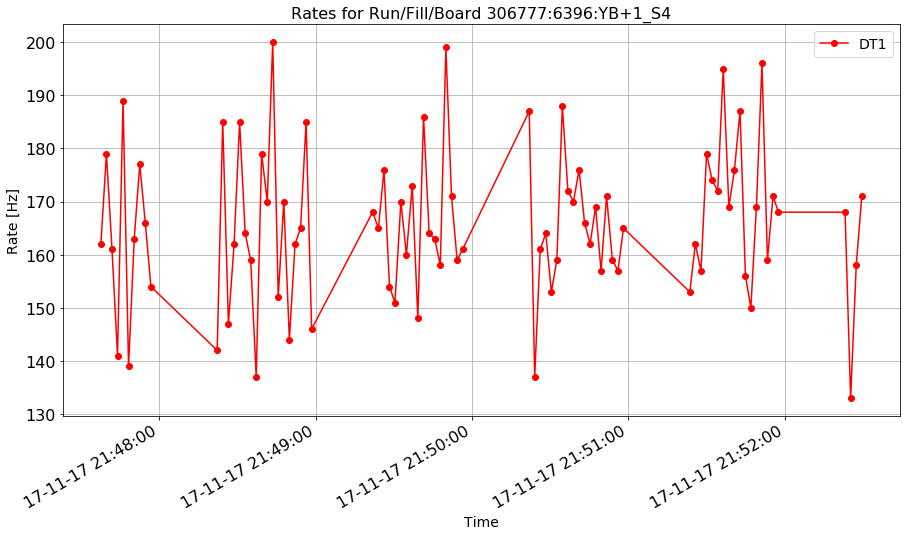

In [33]:
def plot_rate(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();


plot_rate(df_rates, "time", "DT1", "YB+1_S4", "Rates for Run/Fill/Board "+int_lumi["run:fill"][2]+":YB+1_S4")

In [34]:
df_rates["ls"] = -1
df_rates["start"] = -1
df_rates["end"] = -1
df_rates["lumi"] = -1.0

#print df_rates["ls"]

In [35]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        result = (start <= x <= end)
        return result
    else:
        return start <= x or x <= end

def assignLS(df1, df2):
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        rate_time = pd.to_datetime(row1["time"])
        time0 = df2["time"].iloc[0]
        if rate_time <= time0:
            continue;
        for index2, row2 in df2.iterrows():
            run2 = row2["run"]
            if (run1 != run2):
                continue;
            time1 = pd.to_datetime(row2["time"])
            time2 = pd.to_datetime(row2["time_end"])
            if time_in_range(time1, time2, rate_time):
                df1.set_value(index1, 'ls', row2["ls_start"])
                df1.set_value(index1, 'start', row2["time"])
                df1.set_value(index1, 'end', row2["time_end"])
                df1.set_value(index1, 'lumi', row2["delivered"])
                break
assignLS(df_rates, int_lumi2)

In [36]:
#print df_rates[df_rates["ls"] >= 0]

In [37]:
df_rates = df_rates[df_rates.ls > 0]
df_rates["wheel"].replace(regex=True,inplace=True,to_replace=r'YB',value=r'')
df_rates["sector"].replace(regex=True,inplace=True,to_replace=r'S',value=r'')
df_rates["wheel"] = df_rates["wheel"].astype('int')
df_rates["sector"] = df_rates["sector"].astype('int')
#print df_rates

In [38]:
df_chamber = df_rates["board"]
df_chamber = df_chamber[df_chamber.duplicated() == False]
#print df_chamber

algos = ["RPC1", "RPC2", "RPC3", "RPC4","DT1", "DT2", "DT3", "DT4", "DT5"]
resultAverage = []
for x in algos:
    #print x
    for y in df_chamber:
        #print y
        rate = df_rates[df_rates["board"] == y]
        rule = rate.duplicated(subset=["run", "wheel", "sector", "ls", "lumi", "start", "end"])
        count = (rule == False).sum()
        #print count
        for i in range(count):
            #print rate[rate["ls"] == i]
            rate2 = rate[rate["ls"] == (i+1)]
            #print rate2[x]
            std = round(rate2[x].std(), 1)
            mean = round(rate2[x].mean(), 1)
            #print mean, std
            indexes = rate2[x].index
            #print i+1, indexes
            resultAverage.append([x, indexes, mean, std])
            #print resultAverage

In [39]:
#print df_rates[df_rates["board"] == "YB0_S2"]["RPC1"]
#print df_rates[df_rates["board"] == "YB0_S1"]["RPC1"]

In [40]:
rule = df_rates.duplicated(subset=["run", "wheel", "sector", "ls", "lumi"])
print rule.sum()
df_rates = df_rates[rule == False]

3741


In [41]:
for index, row in df_rates.iterrows():
    if row["board"] == "YB0_S1":
        print index, row["run"], row["board"], row["ls"], row["lumi"], row["RPC1"]

600 306777 YB0_S1 1 215.711 1939
1200 306777 YB0_S1 2 215.755 1783
1680 306777 YB0_S1 3 215.599 2078
1920 306777 YB0_S1 4 215.552 2125
2610 306777 YB0_S1 5 215.477 1756
2700 306777 YB0_S1 6 215.449 1962
3240 306777 YB0_S1 7 215.395 2030
3780 306777 YB0_S1 8 215.292 1971
3900 306777 YB0_S1 9 215.336 2385
4500 306777 YB0_S1 10 215.181 1702
4800 306777 YB0_S1 11 215.192 1963


In [44]:
for obj in resultAverage:
    for index, row in df_rates.iterrows():
        if index in obj[1]:
            #df_rates.set_value(index, obj[0], obj[2])
            df_rates.loc[index, obj[0]] = obj[2]

RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1
RPC1


RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3
RPC3


DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2
DT2


DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5
DT5


In [45]:
for index, row in df_rates.iterrows():
    if row["board"] == "YB0_S1":
        print index, row["run"], row["board"], row["ls"], row["lumi"], row["RPC1"]

600 306777 YB0_S1 1 215.711 1778.3
1200 306777 YB0_S1 2 215.755 1938.5
1680 306777 YB0_S1 3 215.599 2027.5
1920 306777 YB0_S1 4 215.552 1854.5
2610 306777 YB0_S1 5 215.477 1786.5
2700 306777 YB0_S1 6 215.449 1973.0
3240 306777 YB0_S1 7 215.395 2004.7
3780 306777 YB0_S1 8 215.292 1936.0
3900 306777 YB0_S1 9 215.336 1770.7
4500 306777 YB0_S1 10 215.181 1721.4
4800 306777 YB0_S1 11 215.192 1995.3
